## Speech Analytics

In [4]:
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


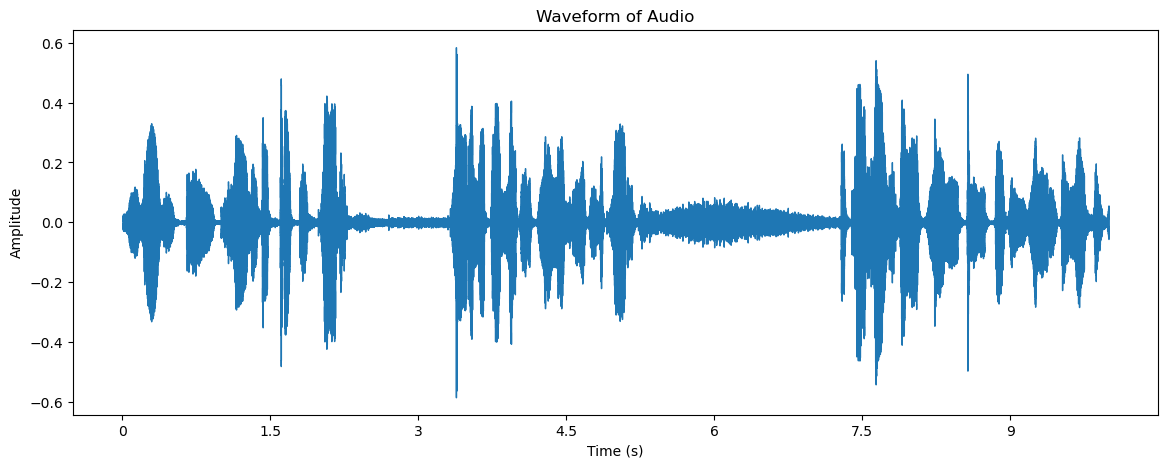

In [51]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
audio_path = "Fluffy Goes To India ｜ Gabriel Iglesias [ux8GZAtCN-M].mp3"
y, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[30*sr:40*sr], sr=sr)
plt.title("Waveform of Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


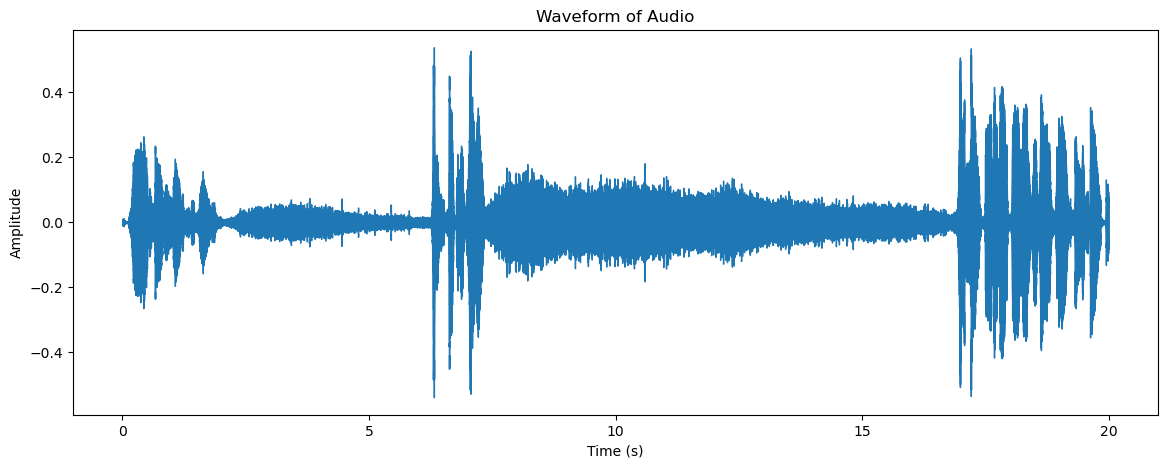

In [53]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[90*sr:110*sr], sr=sr)
plt.title("Waveform of Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

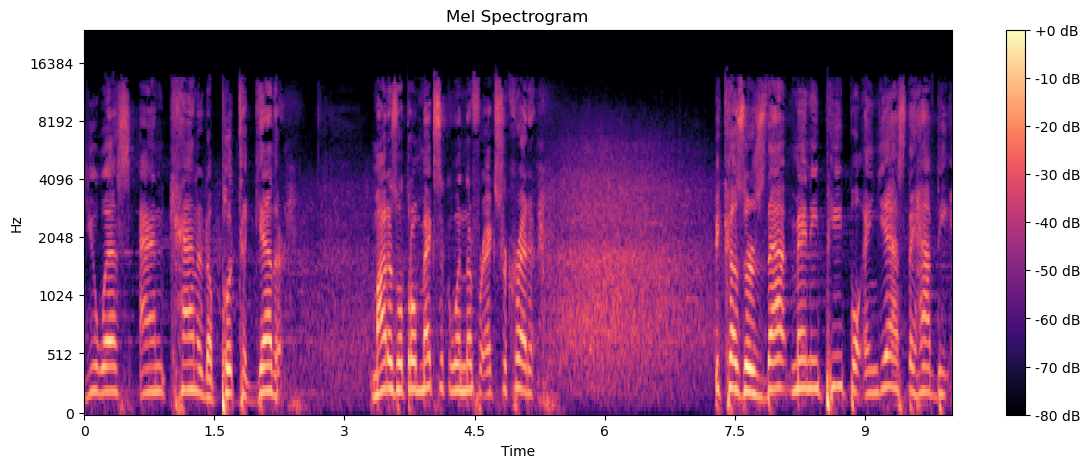

In [55]:
import numpy as np
# Compute the Mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=y[30*sr:40*sr], sr=sr)

# Convert to decibels
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

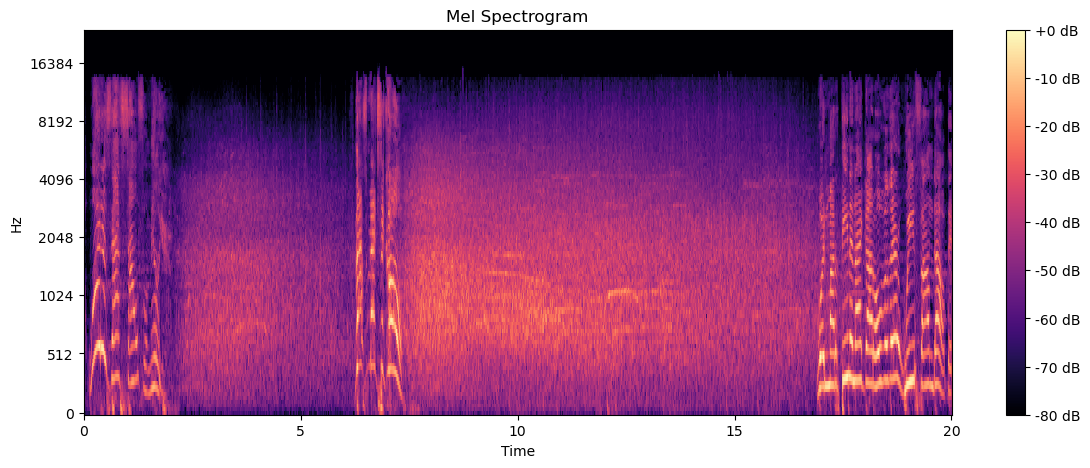

In [57]:

spectrogram = librosa.feature.melspectrogram(y=y[90*sr:110*sr], sr=sr)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

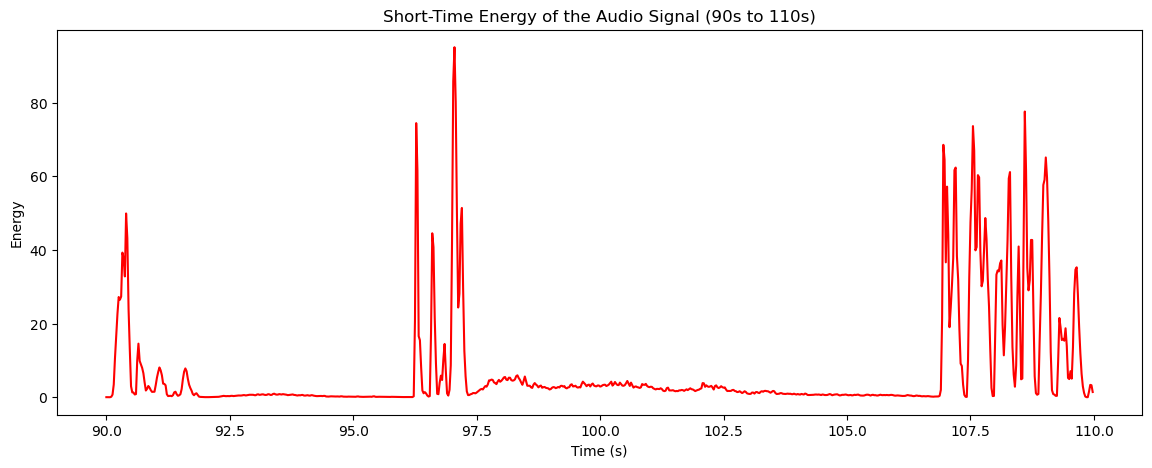

In [59]:

# Subselect the desired time region: 90 to 110 seconds
start_time = 90  # in seconds
end_time = 110   # in seconds
y = y[start_time * sr : end_time * sr]

# Calculate the Short-Time Energy
frame_length = int(0.05 * sr)  # 50 ms frames
hop_length = int(0.025 * sr)   # 25 ms hop between frames

# Compute the energy for each frame
energy = np.array([
    np.sum(np.abs(y[i:i + frame_length]**2))
    for i in range(0, len(y), hop_length)
])

# Create a time array for plotting
times = np.arange(len(energy)) * hop_length / sr + start_time  # Add start_time to align with original time

# Plot the energy against time
plt.figure(figsize=(14, 5))
plt.plot(times, energy, color='red')
plt.title("Short-Time Energy of the Audio Signal (90s to 110s)")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.show()

#### Manual Identification : Example 2 
This time we compare this to the subtitles of a video that have been manually annotated. They are more reliable in capturing audience reactions

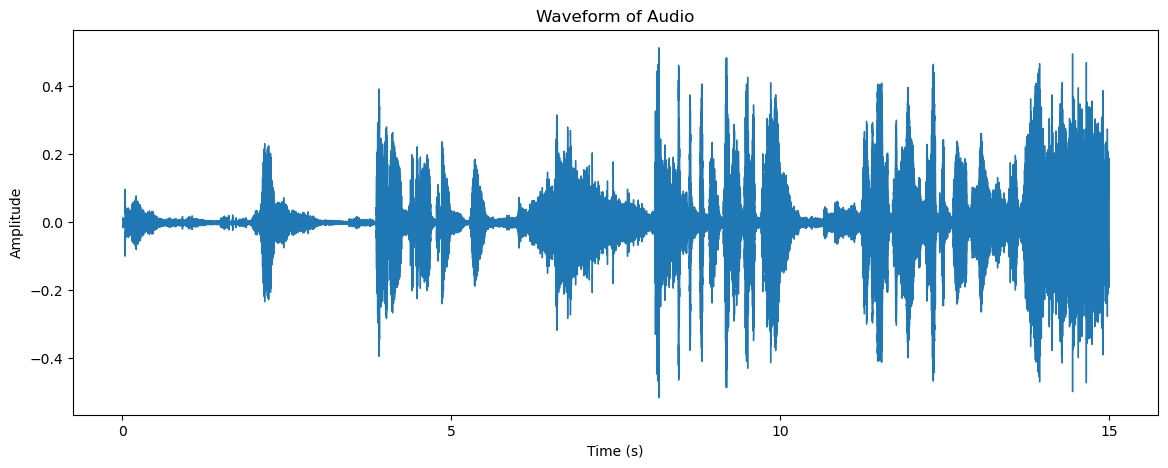

In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
audio_path = "audio_files/Jo Koy： Comedy Central Presents - Full Special.mp3"
y, sr = librosa.load(audio_path, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[50*sr:65*sr], sr=sr)
plt.title("Waveform of Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


## Trying to extract laughter timestamps

In [21]:
# install all dependencies except triton
!pip install numba numpy torch tqdm more-itertools tiktoken==0.3.3
# install whisper-at without any dependency
!pip install --no-deps whisper-at  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 7.6 MB/s eta 0:00:00
  Using cached whisper_at-0.5-py3-none-any.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.9 MB/s eta 0:00:00


### This works - a coarse laughter tagger using speech
#### This should help generate supervised training data

In [1]:
import whisper_at as whisper


model = whisper.load_model("base")
audio_tagging_time_resolution = 10
result = model.transcribe("audio_files/Jo Koy： Comedy Central Presents - Full Special.mp3", at_time_res=audio_tagging_time_resolution)

include_class_list = [16, 18, 21, 63, 66, 67]
audio_tag_result2 = whisper.parse_at_label(
    result,
    language='follow_asr',
    top_k=5,  # Adjust if needed to limit the number of classes
    p_threshold=-1,
    include_class_list=include_class_list
)


/opt/anaconda3/lib/python3.11/site-packages/whisper_at/__init__.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/opt/a

## EDA

In [79]:
y.shape

(20512323,)

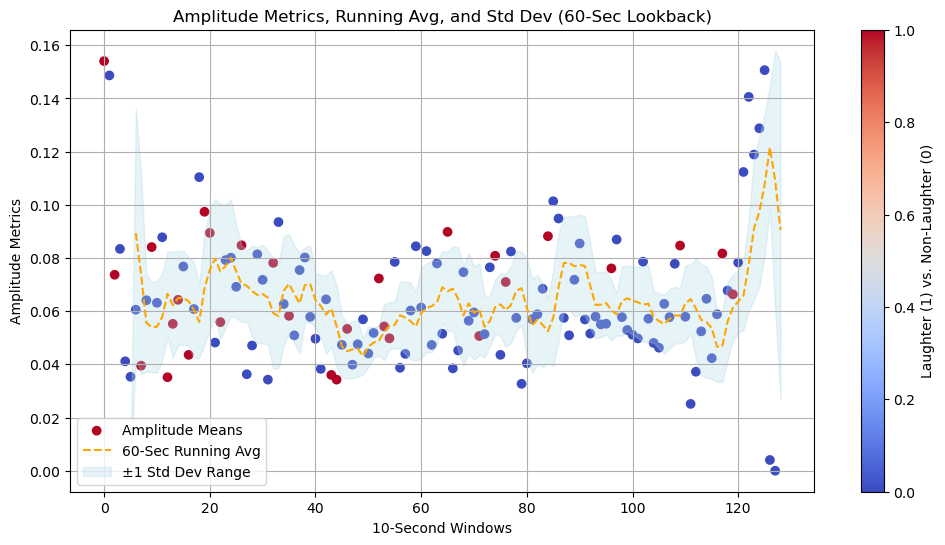

In [115]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_path = "audio_files/Jo Koy： Comedy Central Presents - Full Special.mp3"
y, sr = librosa.load(audio_path, sr=16000, mono=True)

# Normalize the amplitude
y = y / np.max(np.abs(y))

# Calculate amplitude variation
window_size = int(sr * 10)  # 10-second windows
amplitude_means = [
    np.mean(np.abs(y[i:i + window_size]))
    for i in range(0, len(y), window_size)
]
amplitude_stds = [
    np.std(np.abs(y[i:i + window_size]))
    for i in range(0, len(y), window_size)
]

# Dynamic lookback window
lookback = 6  # Number of 10-second windows for running stats
running_avg = []
running_std = []

for i in range(len(amplitude_means)):
    if i >= lookback:
        running_avg.append(np.mean(amplitude_means[i - lookback:i]))
        running_std.append(np.std(amplitude_means[i - lookback:i]))
    else:
        running_avg.append(None)  # Pad with None for the first few points
        running_std.append(None)  # Pad with None for the first few points

# Calculate upper and lower bounds for ±1.96 * std dev
upper_bound = [
    running_avg[i] + 1 * running_std[i] if running_avg[i] is not None else None
    for i in range(len(running_avg))
]
lower_bound = [
    running_avg[i] - 1 * running_std[i] if running_avg[i] is not None else None
    for i in range(len(running_avg))
]

# Visualize the results
plt.figure(figsize=(12, 6))

# Scatter plot of amplitude means
plt.scatter(range(len(targets)-1), amplitude_means[:-1], c=targets[1:], cmap="coolwarm", label="Amplitude Means")

# Plot running average
plt.plot(running_avg, linestyle='--', color='orange', label=f"{lookback * 10}-Sec Running Avg")

# Plot shaded area for ±1.96 std dev
plt.fill_between(
    range(len(running_avg)),
    [lb if lb is not None else 0 for lb in lower_bound],
    [ub if ub is not None else 0 for ub in upper_bound],
    color="lightblue",
    alpha=0.3,
    label="±1 Std Dev Range",
)

# Add labels, legend, and grid
plt.colorbar(label="Laughter (1) vs. Non-Laughter (0)")
plt.xlabel("10-Second Windows")
plt.ylabel("Amplitude Metrics")
plt.title(f"Amplitude Metrics, Running Avg, and Std Dev ({lookback * 10}-Sec Lookback)")
plt.legend()
plt.grid()
plt.show()

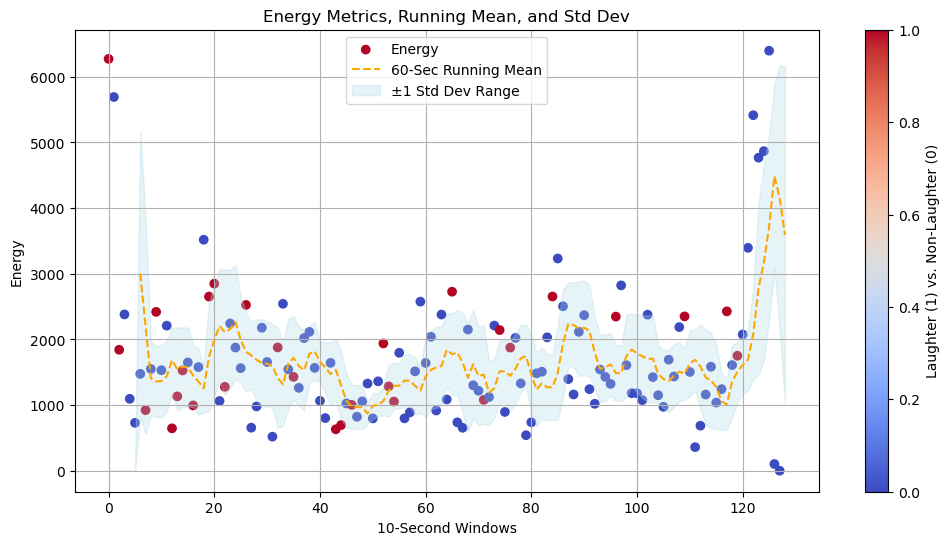

In [125]:
# Calculate energy (sum of squared amplitudes)
window_size = int(sr * 10)  # 10-second windows
energy = [
    np.sum(np.square(y[i:i + window_size]))
    for i in range(0, len(y), window_size)
]

# Dynamic lookback window for running mean and std
lookback = 6  # Number of 10-second windows for running stats
running_energy_mean = []
running_energy_std = []

for i in range(len(energy)):
    if i >= lookback:
        running_energy_mean.append(np.mean(energy[i - lookback:i]))
        running_energy_std.append(np.std(energy[i - lookback:i]))
    else:
        running_energy_mean.append(None)  # Pad with None for the first few points
        running_energy_std.append(None)  # Pad with None for the first few points

# Calculate upper and lower bounds for ±1 std dev
upper_bound_energy = [
    re + 1 * rs if re is not None else None
    for re, rs in zip(running_energy_mean, running_energy_std)
]
lower_bound_energy = [
    re - 1 * rs if re is not None else None
    for re, rs in zip(running_energy_mean, running_energy_std)
]

# Visualize the energy plot
plt.figure(figsize=(12, 6))

# Energy plot
plt.scatter(range(len(energy)-1), energy[:-1], c=targets[1:], cmap="coolwarm", label="Energy")
plt.plot(running_energy_mean, linestyle='--', color='orange', label=f"{lookback * 10}-Sec Running Mean")
plt.fill_between(
    range(len(running_energy_mean)),
    [lb if lb is not None else 0 for lb in lower_bound_energy],
    [ub if ub is not None else 0 for ub in upper_bound_energy],
    color="lightblue",
    alpha=0.3,
    label="±1 Std Dev Range",
)

# Add labels, legend, and grid
plt.xlabel("10-Second Windows")
plt.colorbar(label="Laughter (1) vs. Non-Laughter (0)")
plt.ylabel("Energy")
plt.title("Energy Metrics, Running Mean, and Std Dev")
plt.legend()
plt.grid()
plt.show()

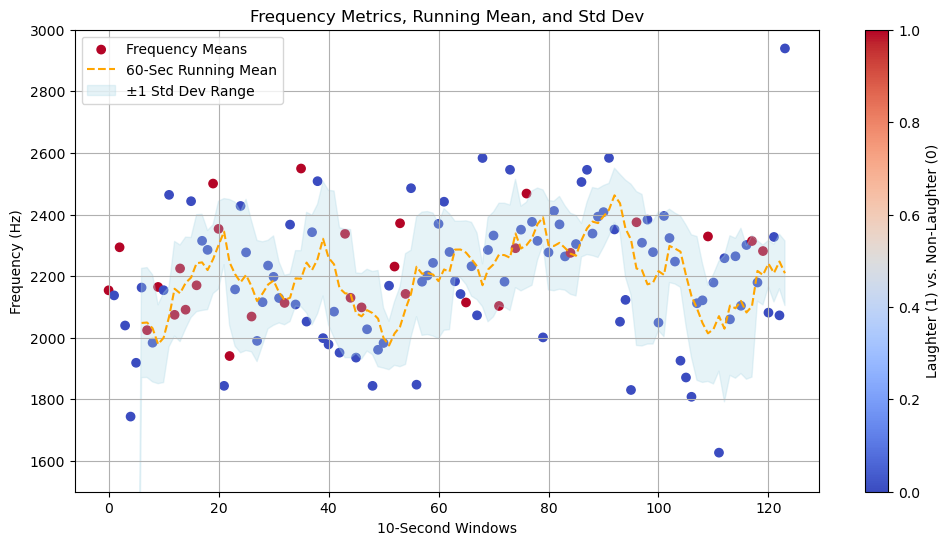

In [145]:

# Calculate spectral centroid for the entire audio
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)

# Convert spectral centroids into 10-second windows
window_size = int(sr * 10 // 512)  # 10-second windows in terms of frames
frequency_means = [
    np.mean(spectral_centroids[:, i:i + window_size])
    for i in range(0, spectral_centroids.shape[1], window_size)
]

# Dynamic lookback window for running mean and std
lookback = 6  # Number of 10-second windows for running stats
running_frequency_mean = []
running_frequency_std = []

for i in range(len(frequency_means)):
    if i >= lookback:
        running_frequency_mean.append(np.mean(frequency_means[i - lookback:i]))
        running_frequency_std.append(np.std(frequency_means[i - lookback:i]))
    else:
        running_frequency_mean.append(None)  # Pad with None for the first few points
        running_frequency_std.append(None)  # Pad with None for the first few points

# Calculate upper and lower bounds for ±1 std dev
upper_bound_frequency = [
    rf + 1 * rs if rf is not None else None
    for rf, rs in zip(running_frequency_mean, running_frequency_std)
]
lower_bound_frequency = [
    rf - 1 * rs if rf is not None else None
    for rf, rs in zip(running_frequency_mean, running_frequency_std)
]

# Visualize the frequency plot
plt.figure(figsize=(12, 6))

# Frequency plot
plt.scatter(range(len(frequency_means)-5), frequency_means[:-5], c=targets[1:-4], cmap="coolwarm", label="Frequency Means")
plt.plot(running_frequency_mean[:-5], linestyle='--', color='orange', label=f"{lookback * 10}-Sec Running Mean")
plt.fill_between(
    range(len(running_frequency_mean)-5),
    [lb if lb is not None else 0 for lb in lower_bound_frequency[:-5]],
    [ub if ub is not None else 0 for ub in upper_bound_frequency[:-5]],
    color="lightblue",
    alpha=0.3,
    label="±1 Std Dev Range",
)

# Add labels, legend, and grid
plt.xlabel("10-Second Windows")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Laughter (1) vs. Non-Laughter (0)")
plt.ylim(1500, 3000)  # Set y-axis range
plt.title("Frequency Metrics, Running Mean, and Std Dev")
plt.legend()
plt.grid()
plt.show()

## Architecture built from scratch

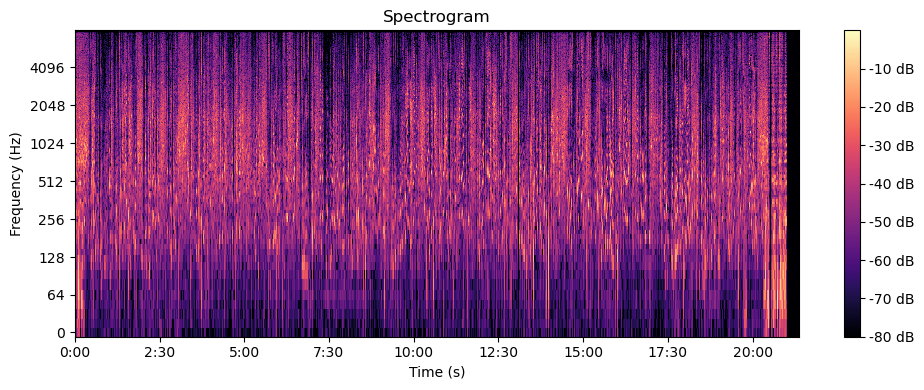

Spectrogram shape: (513, 20032)


In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the audio file
audio_path = "audio_files/Jo Koy： Comedy Central Presents - Full Special.mp3"
y, sr = librosa.load(audio_path, sr=16000, mono=True)

# Normalize the amplitude
y = y / np.max(np.abs(y))

# Generate the spectrogram
# Set lower resolution parameters
n_fft = 1024  # Lower frequency resolution
hop_length = 1024  # Higher temporal step size (faster computation)

S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Save and visualize the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig("spectrogram.png")  # Save for inspection
plt.show()

# Convert spectrogram into a NumPy array
spectrogram = np.abs(S_dB)  # Use this as input to the CNN
print("Spectrogram shape:", spectrogram.shape)

Design questions
- Choosing the step size
- What is FFT, how is that set?

Why CNN?
CNNs are widely used for audio because:

Pattern Recognition:
	•	They excel at recognizing local patterns like transitions in pitch or energy. These patterns are spatially localized and occur across adjacent time-frequency points.
<br>
Dimensionality Reduction:
	•	By applying convolutional filters, CNNs reduce the input size significantly while retaining meaningful features.
<br>
Feature Hierarchies:
	•	CNNs build hierarchies of features—lower layers detect simple features (e.g., sharp frequency changes), while deeper layers detect complex patterns (e.g., rhythm).


In [5]:
import whisper_at as whisper

# Load WhisperAT model
model = whisper.load_model("base")

# Transcribe with audio tagging resolution of 10 seconds
audio_tagging_time_resolution = 10
result = model.transcribe(audio_path, at_time_res=audio_tagging_time_resolution)

# Parse audio tags with the specified class list
include_class_list = [16, 18, 21, 63, 66, 67]  # Define your target classes
audio_tag_result2 = whisper.parse_at_label(
    result,
    language='follow_asr',
    top_k=5,
    p_threshold=-1,
    include_class_list=include_class_list
)



/opt/anaconda3/lib/python3.11/site-packages/whisper_at/__init__.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/opt/a

In [6]:
# Create target labels for each 10-second window
targets = [1 if len(entry['audio tags']) > 0 else 0 for entry in audio_tag_result2]

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# Define the CNN model
def build_cnn(input_shape):
    model = Sequential([
        # Convolutional Layer 1
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Layer 2
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Global Pooling Layer
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model
    
# Example input shape: (Frequency bins, Time steps, 1 channel)
input_shape = (156, 513, 1)
model = build_cnn(input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 154, 511, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 77, 255, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 253, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 126, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data with 10-second chunks
def create_data_10_second_chunks(spectrogram, targets, input_shape, chunk_width):
    """
    Creates data for a CNN with chunks representing 10-second windows.
    """
    X, y = [], []
    hop_length = chunk_width  # Non-overlapping chunks

    # Calculate maximum possible chunks to avoid index errors
    max_chunks = min(len(targets), (spectrogram.shape[1] - chunk_width) // hop_length + 1)

    for idx in range(max_chunks):
        i = idx * hop_length  # Starting frame for this chunk

        # Extract one chunk of the spectrogram
        chunk = spectrogram[:, i:i + chunk_width]

        # Resize if necessary to match the input shape
        resized_chunk = np.resize(chunk, input_shape[:2])  # Resize to (frequency bins, time steps)

        X.append(resized_chunk.T)  # Transpose to match (time steps, frequency bins)
        y.append(targets[idx])  # Map target for this window

    # Convert to numpy arrays and add the channel dimension for CNN
    X = np.array(X)[..., np.newaxis]  # Add channel dimension
    y = np.array(y)
    return X, y

# Define input shape for the CNN (e.g., frequency bins, time steps, channels)
chunk_width = 156  # Frames corresponding to 10 seconds
input_shape = (513, chunk_width, 1)

# Create training and testing data
X, y = create_data_10_second_chunks(spectrogram, targets, input_shape, chunk_width)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes for validation
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (102, 156, 513, 1)
X_test shape: (26, 156, 513, 1)
y_train shape: (102,)
y_test shape: (26,)


frame_duration = hop_length/ Sampling_rate = 1024/16000 = 0.064 seconds per frame
frames_per_10_sec = 10 / frame_duration = 10/0.064 = 156.25
frequency_bins = n_fft / 2 + 1 = 1024/2 + 1 = 513

In [49]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    verbose=1
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6292 - loss: 1.8945 - val_accuracy: 0.7692 - val_loss: 1.1772
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7082 - loss: 1.2972 - val_accuracy: 0.7692 - val_loss: 0.6418
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7283 - loss: 0.8284 - val_accuracy: 0.7692 - val_loss: 0.5365
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5464 - loss: 0.8370 - val_accuracy: 0.7692 - val_loss: 0.5862
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7580 - loss: 0.6654 - val_accuracy: 0.7692 - val_loss: 0.5389
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6782 - loss: 0.6451 - val_accuracy: 0.7692 - val_loss: 0.5423
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7983 - loss: 0.5636 - val_accuracy: 0.7692 - val_loss: 0.5396
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7468 - loss: 0.5645 - val_accuracy: 0.7692 - val_loss: 0.5417


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7692 - loss: 0.5457
Test Loss: 0.5457436442375183
Test Accuracy: 0.7692307829856873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


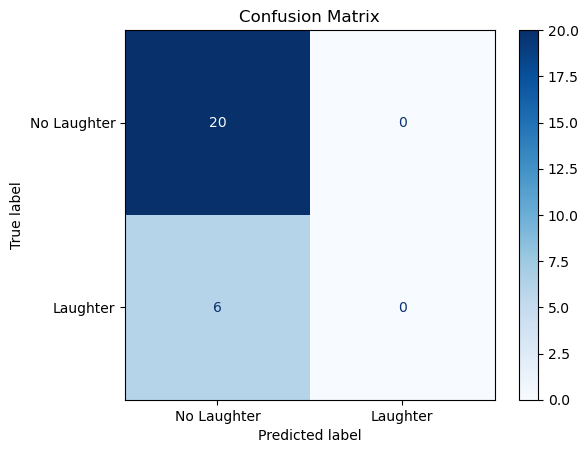

In [52]:
# Evaluate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### Trying overlapping windows
I believe that 10 second disjoint windows will allow the model less recent information to predict laughter. If we use overlapping windows, we can have finer granualirity around which interval people laughed. This might give better results. For example, we keep the overlap to be 5 seconds, then by comparing across windows we can pinpoint better in which 5 second window people laughed.

### Enhancing with LSTM Layer

In [160]:
def create_sequential_data(X, y, lookback):
    """
    Reshapes the data into sequences for LSTM input.
    Args:
        X: Input data of shape (n_samples, time_steps, features).
        y: Target data of shape (n_samples,).
        lookback: Number of previous intervals to consider.
    Returns:
        X_seq: Sequential input of shape (n_samples - lookback, lookback, features).
        y_seq: Target data aligned with sequences.
    """
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i - lookback:i])  # Previous `lookback` intervals
        y_seq.append(y[i])  # Target corresponds to the last interval in the sequence
    return np.array(X_seq), np.array(y_seq)

lookback = 10
X_seq, y_seq = create_sequential_data(X_train, y_train, lookback)

In [162]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Dropout, Flatten

# Define the CNN + LSTM model
def build_cnn_lstm(input_shape, lookback):
    # Input for the CNN
    cnn_input = Input(shape=input_shape)
    
    # CNN Layers
    x = Conv2D(16, kernel_size=(3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)  # Flatten spatial dimensions
    
    # Wrap CNN in TimeDistributed to process each time step
    cnn_model = Model(inputs=cnn_input, outputs=x)

    # Input for the sequential model
    sequential_input = Input(shape=(lookback, *input_shape))  # (lookback, time_steps, features)
    x = TimeDistributed(cnn_model)(sequential_input)  # Apply CNN to each time step
    x = LSTM(64, return_sequences=False)(x)  # LSTM to capture temporal dependencies
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Build and return the model
    model = Model(inputs=sequential_input, outputs=output)
    return model

# Define the input shape (frequency bins, time steps, channels)
input_shape = (156, 513, 1)  # Dimensions of each time interval
model = build_cnn_lstm(input_shape, lookback)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 156, 513,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 149184)     │         4,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │    38,207,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,216,769 (145.79 MB)

 Trainable params: 38,216,769 (145.79 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
# Reshape the test data similarly
X_test_seq, y_test_seq = create_sequential_data(X_test, y_test, lookback)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_seq, y_seq,
    validation_data=(X_test_seq, y_test_seq),
    batch_size=16,
    epochs=100,
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 866ms/step - accuracy: 0.7573 - loss: 0.6089 - val_accuracy: 0.6875 - val_loss: 0.6247
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 811ms/step - accuracy: 0.7706 - loss: 0.5554 - val_accuracy: 0.6875 - val_loss: 0.6313
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 816ms/step - accuracy: 0.7919 - loss: 0.5616 - val_accuracy: 0.6875 - val_loss: 0.6331
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 812ms/step - accuracy: 0.6991 - loss: 0.6129 - val_accuracy: 0.6875 - val_loss: 0.6315
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 813ms/step - accuracy: 0.7405 - loss: 0.6316 - val_accuracy: 0.6875 - val_loss: 0.6309
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 812ms/step - accuracy: 0.8000 - loss: 0.5291 - val_accuracy: 0.6875 - val_loss: 0.6341
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 816ms/step - accuracy: 0.7412 - loss: 0.5732 - val_accuracy: 0.6875 - val_loss: 0.6340
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 836ms/step - accuracy: 0.7260 - loss: 0.6177 - val_accuracy: 0.6875 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6875 - loss: 0.6313
Test Loss: 0.6312788128852844
Test Accuracy: 0.6875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


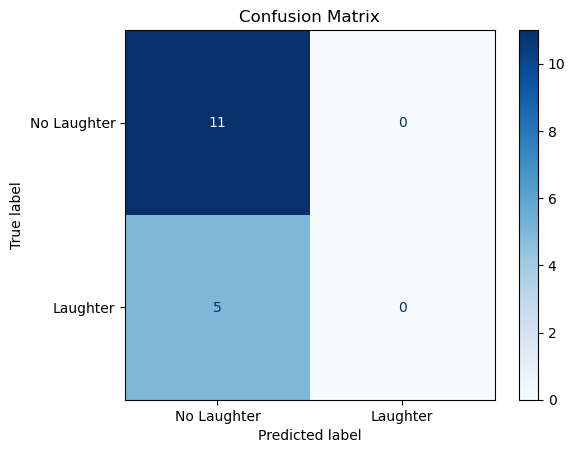

In [174]:
X_test_seq, y_test_seq = create_sequential_data(X_test, y_test, lookback)
# Evaluate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test_seq)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Learnings
- Current models either has too few data points, or is too simple to predict any thing. I think it is the latter, because the model is just predicting the base class
- In the current version of model - audio segment at interval T is used to predict laughter at T. Which is not technically correct

## Using larger batch of audio files

In [184]:
def compute_spectrograms_with_finer_resolution(folder_path, sr=16000, window_size=10, n_fft=2048, hop_length=512):
    """
    Compute high-resolution spectrograms for all audio files and return spectrograms with indices.
    """
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".mp3")]
    spectrograms = []
    indices = []

    for file in audio_files:
        audio_path = os.path.join(folder_path, file)
        y, _ = librosa.load(audio_path, sr=sr, mono=True)
        y = y / np.max(np.abs(y))  # Normalize amplitude
        
        # Compute the spectrogram
        S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(S)
        
        # Split into 10-second windows
        num_samples_per_window = sr * window_size
        for i in range(0, len(y), num_samples_per_window):
            start_time = i // sr
            end_time = (i + num_samples_per_window) // sr
            
            # Extract the spectrogram for this window
            start_frame = i // hop_length
            end_frame = (i + num_samples_per_window) // hop_length
            spectrogram_chunk = spectrogram[:, start_frame:end_frame]

            spectrograms.append(spectrogram_chunk)
            indices.append(f"{file}_interval_{start_time}-{end_time}")
    
    return spectrograms, indices

In [197]:
import os
import whisper_at as whisper

# Load the Whisper model
model = whisper.load_model("base")

# Parameters for audio tagging
audio_tagging_time_resolution = 10  # 10-second intervals
include_class_list = [16, 18, 21, 63, 66, 67]  # Classes of interest

def generate_targets(folder_path):
    """
    Generate target vectors for all audio files in a folder.
    Each target corresponds to a 10-second interval and indicates the presence of laughter.
    """
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".mp3")]
    targets_dict = {}  # To store targets for each audio file
    
    for file in audio_files:
        audio_path = os.path.join(folder_path, file)
        
        # Transcribe the audio file with Whisper-AT
        result = model.transcribe(audio_path, at_time_res=audio_tagging_time_resolution)
        
        # Parse the results to extract laughter tags
        audio_tag_result = whisper.parse_at_label(
            result,
            language='follow_asr',
            top_k=5,  # Adjust if needed to limit the number of classes
            p_threshold=-1,
            include_class_list=include_class_list
        )
        
        # Generate the targets vector
        targets = []
        for entry in audio_tag_result:
            if len(entry['audio tags']) > 0:  # Check if any relevant tags are present
                targets.append(1)  # Laughter detected
            else:
                targets.append(0)  # No laughter detected
        
        # Store the targets vector for this audio file
        targets_dict[file] = targets
    
    return targets_dict

# Path to the folder containing audio files
folder_path = "audio_files_22_nov"

# Generate targets for all audio files
targets_dict = generate_targets(folder_path)

# Example: Access targets for a specific file
for file, targets in targets_dict.items():
    print(f"{file}: {targets[:10]}")  # Print the first 10 targets for verification

/opt/anaconda3/lib/python3.11/site-packages/whisper_at/__init__.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/opt/a

When You’re the Only Black Friend in the Group - Jourdain Fisher - Stand-Up Featuring.mp3: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
I'm Not Done Yet. Brad Upton - Full Special.mp3: [1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Conrad Molden： DANGLISH (2019) Full Special - English Subtitles.mp3: [0, 0, 1, 1, 0, 1, 1, 0, 1, 1]
Katie Hannigan： Feeling of Emptiness ｜ FULL SPECIAL.mp3: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
＂I Am Still Single＂ Stand Up Comedy by Saikiran.mp3: [0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
Cedric The Entertainer Needs Subtitles For His Cousins ｜ Netflix Is A Joke.mp3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Michael Yo ｜ Black Dad, Korean Mom, White Wife ｜ I Never Thought.mp3: [0, 0, 0, 1, 0, 1, 0, 0, 1, 1]
Kevin Hart's House Got Robbed ｜ Netflix Is A Joke.mp3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
“I Sold Mansions to Janitors” - Tim Dillon - Full Special.mp3: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
What Austin, Texas Is Like - Josh Johnson.mp3: [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
“It’s Called the Internet”- Leo Allen - Full Special.mp3

In [198]:
import csv

def save_targets_to_csv(targets_dict, output_csv, interval_duration=10):
    """
    Save the targets_dict to a CSV file.
    
    Parameters:
        targets_dict (dict): Dictionary with audio file names as keys and targets as values.
        output_csv (str): Path to the output CSV file.
        interval_duration (int): Duration of each interval in seconds (default: 10).
    """
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(["audio_file_name", "interval_start", "interval_end", "target"])
        
        # Write the data
        for audio_file, targets in targets_dict.items():
            for i, target in enumerate(targets):
                interval_start = i * interval_duration
                interval_end = interval_start + interval_duration
                writer.writerow([audio_file, interval_start, interval_end, target])

# Example usage
output_csv = "targets_output.csv"
save_targets_to_csv(targets_dict, output_csv)
print(f"Targets saved to {output_csv}")

Targets saved to targets_output.csv


## Analyze the target file - some clips don't have the laughter tags (Analyze those for ground truth)

-- there are audio clips where LLM is not able to identify laughter <br>
-- either train with whatever the LLM is able to get now, or use subtitles to make predictions


In [3]:
import pandas as pd
target_csv = pd.read_csv('targets_output.csv')
target_csv.head()

,audio_file_name,interval_start,interval_end,target
0,When You’re the Only Black Friend in the Group...,0,10,0
1,When You’re the Only Black Friend in the Group...,10,20,0
2,When You’re the Only Black Friend in the Group...,20,30,0
3,When You’re the Only Black Friend in the Group...,30,40,0
4,When You’re the Only Black Friend in the Group...,40,50,0


In [8]:
import pandas as pd

# Load the data
file_path = 'targets_output.csv'  # Replace with the correct path
data = pd.read_csv(file_path)

# Sort the data by audio_name and interval_start for proper alignment
data = data.sort_values(by=['audio_file_name', 'interval_start']).reset_index(drop=True)

# Create a new dataframe to store the results
processed_data = []

# Group by 'audio_name'
grouped = data.groupby('audio_file_name')

# Process each group
for name, group in grouped:
    # Shift the 'target' column to align with the next 10-second interval
    group['next_target'] = group['target'].shift(-1)
    
    # Drop the first row of each group (to ensure no forward mapping error)
    group = group.iloc[:-1]
    
    # Append the processed group to the final dataframe
    processed_data.append(group)

# Concatenate all processed groups
processed_data = pd.concat(processed_data)


In [10]:
processed_data.head()

,audio_file_name,interval_start,interval_end,target,next_target
0,15 Minutes of Katt Williams.mp3,0,10,0,0.0
1,15 Minutes of Katt Williams.mp3,10,20,0,0.0
2,15 Minutes of Katt Williams.mp3,20,30,0,0.0
3,15 Minutes of Katt Williams.mp3,30,40,0,0.0
4,15 Minutes of Katt Williams.mp3,40,50,0,0.0


In [12]:

# Save the processed data
processed_data.to_csv('processed_targets_output.csv', index=False)

print("Processed data has been saved to 'processed_targets_output.csv'")

Processed data has been saved to 'processed_targets_output.csv'


-- write code to fit NN

In [18]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split

# Load the processed target file
processed_data = pd.read_csv("processed_targets_output.csv")

# Configuration for spectrogram chunks
chunk_width = 156  # Frames corresponding to 10 seconds
input_shape = (513, chunk_width, 1)

def generate_spectrogram(audio_file, interval_start, interval_end, sr=16000, n_fft=1024, hop_length=256):
    """
    Generate a spectrogram for the specified interval of an audio file.
    """
    y, _ = librosa.load(audio_file, sr=sr, mono=True, offset=interval_start, duration=(interval_end - interval_start))
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def preprocess_data(df, audio_folder="audio_files_22_nov"):
    """
    Preprocess the data to generate spectrograms and targets for training/testing.
    """
    X, y = [], []
    for _, row in df.iterrows():
        audio_file_path = f"{audio_folder}/{row['audio_file_name']}"
        interval_start = row['interval_start']
        interval_end = row['interval_end']
        
        try:
            # Generate spectrogram for the given interval
            spectrogram = generate_spectrogram(audio_file_path, interval_start, interval_end)
            
            # Resize the spectrogram to the desired input shape (if necessary)
            resized_spectrogram = np.resize(spectrogram, input_shape[:2])
            X.append(resized_spectrogram[..., np.newaxis])  # Add channel dimension
            
            # Append the target
            y.append(row['next_target'])
        except Exception as e:
            print(f"Error processing file {audio_file_path} for interval ({interval_start}, {interval_end}): {e}")
            continue
    
    return np.array(X), np.array(y)

# Preprocess the data
X, y = preprocess_data(processed_data)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5489, 513, 156, 1)
X_test shape: (1373, 513, 156, 1)
y_train shape: (5489,)
y_test shape: (1373,)


In [24]:
sum(y_train)/y_train.shape[0]

0.3106212424849699

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.6510 - loss: 0.8306 - val_accuracy: 0.6897 - val_loss: 0.6265
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.6901 - loss: 0.6213 - val_accuracy: 0.6897 - val_loss: 0.6195
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.6885 - loss: 0.6213 - val_accuracy: 0.6897 - val_loss: 0.6198
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.6834 - loss: 0.6239 - val_accuracy: 0.6897 - val_loss: 0.6193
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.6926 - loss: 0.6200 - val_accuracy: 0.6897 - val_loss: 0.6192
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.6774 - loss: 0.6301 - val_accuracy: 0.6897 - val_loss: 0.6195
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.6862 - loss: 0.6237 - val_accuracy: 0.6897 - val_loss: 0.6193
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.6897 - loss: 0.6217 - 

Test Loss: 0.619283139705658
Test Accuracy: 0.6897305250167847


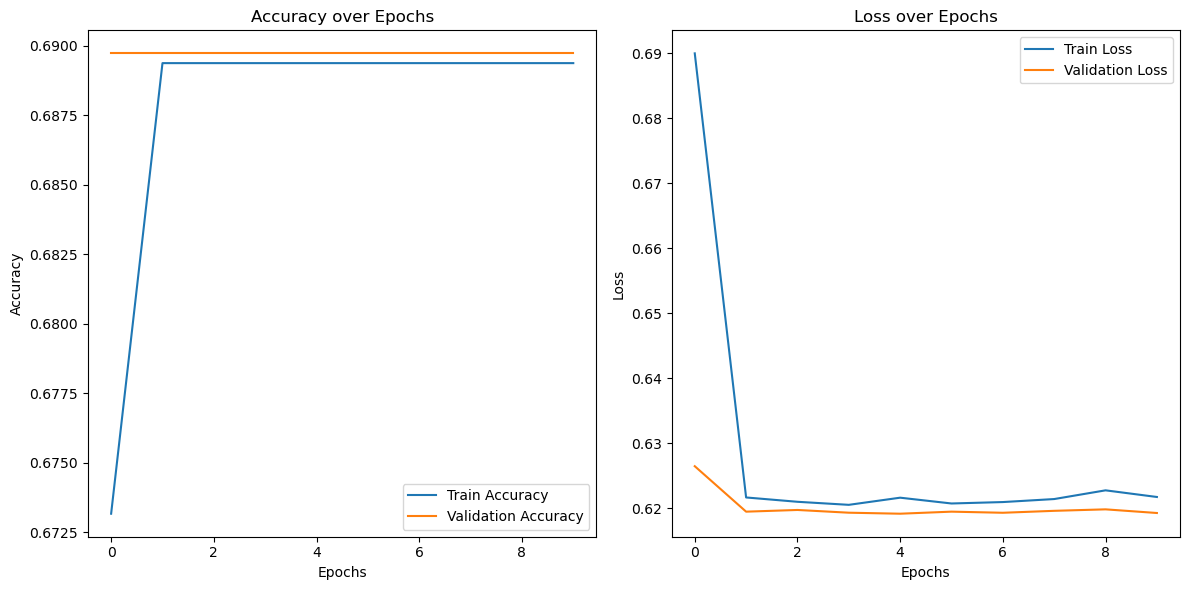

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from sklearn.model_selection import train_test_split

# Define the CNN model
def build_cnn(input_shape):
    model = Sequential([
        # Convolutional Layer 1
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Layer 2
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Global Pooling Layer
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

# Prepare the data (use your preprocessed spectrograms and targets)
# Assuming X and y are already created
input_shape = (513, 156, 1)  # Adjust dimensions to match (frequency bins, time steps, channels)

# Build the model
model = build_cnn(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    verbose=1
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save("cnn_laughter_detection.h5")

# Visualize training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7037 - loss: 0.6080
Test Loss: 0.619283139705658
Test Accuracy: 0.6897305250167847
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


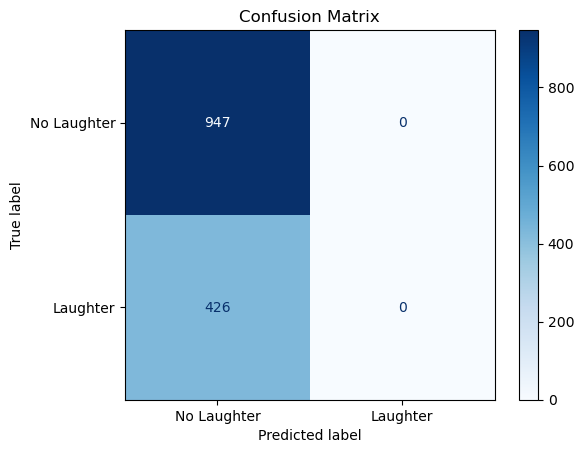

In [28]:
# Evaluate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [30]:
y_pred

array([[0.3103067 ],
       [0.31031168],
       [0.31031597],
       ...,
       [0.31031147],
       [0.31030574],
       [0.31031227]], dtype=float32)

-- model still performing poorly
- new enhancements-
- 1. increase architecture complexity
  2. add lookback
  3. add tailored features such as energy deviation of last 10 sec wrt last 2 min

####  1. Increasing architechture complexity

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

def build_complex_cnn(input_shape):
    model = Sequential([
        # Convolutional Block 1
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Block 2
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Block 3
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Block 4
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Global Pooling Layer
        GlobalAveragePooling2D(),
        
        # Fully Connected Layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

# Example input shape
input_shape = (513, 156, 1)
model = build_complex_cnn(input_shape)
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 511, 154, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 511, 154, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 255, 77, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 253, 75, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 253, 75, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 37, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 35, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 124, 35, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 60, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 7, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,977 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.6513 - loss: 0.8422 - val_accuracy: 0.6897 - val_loss: 0.6243
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.6994 - loss: 0.6224 - val_accuracy: 0.6897 - val_loss: 0.6226
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.6870 - loss: 0.6297 - val_accuracy: 0.6897 - val_loss: 0.6192
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6883 - loss: 0.6235 - val_accuracy: 0.6897 - val_loss: 0.6226
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6824 - loss: 0.6259 - val_accuracy: 0.6897 - val_loss: 0.6200
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6924 - loss: 0.6226 - val_accuracy: 0.6897 - val_loss: 0.6206
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6791 - loss: 0.6300 - val_accuracy: 0.6897 - val_loss: 0.6197
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6889 - loss: 0.6236 - 

Test Loss: 0.6191829442977905
Test Accuracy: 0.6897305250167847


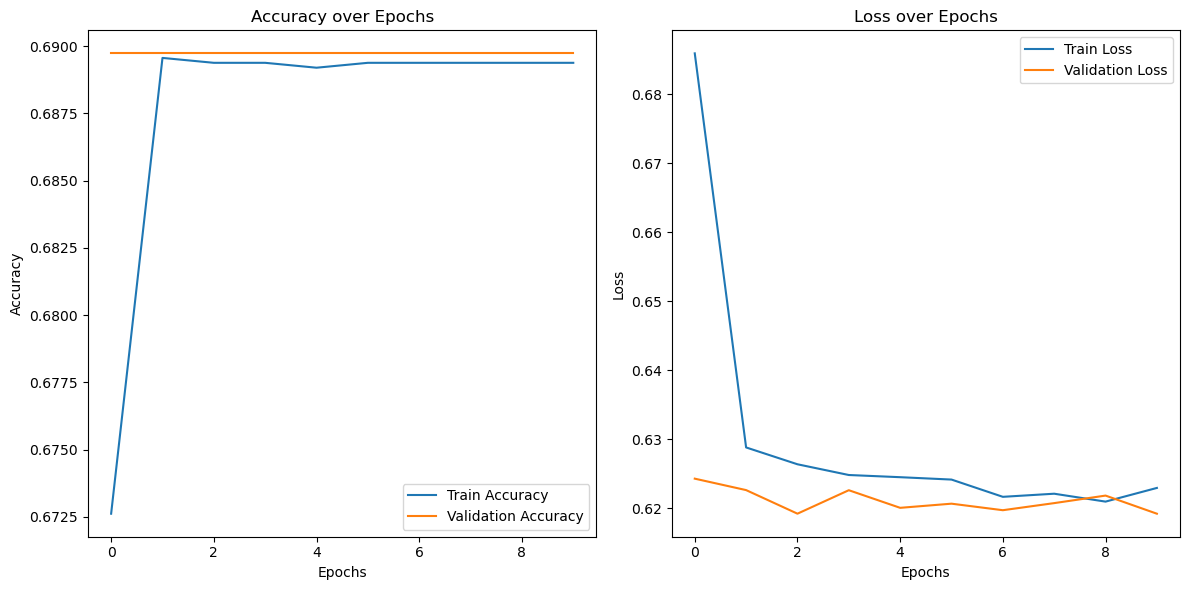

In [44]:
input_shape = (513, 156, 1)  # Adjust dimensions to match (frequency bins, time steps, channels)

# Build the model
model = build_cnn(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    verbose=1
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save("cnn_complex1_laughter_detection.h5")

# Visualize training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7037 - loss: 0.6091
Test Loss: 0.6191829442977905
Test Accuracy: 0.6897305250167847
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


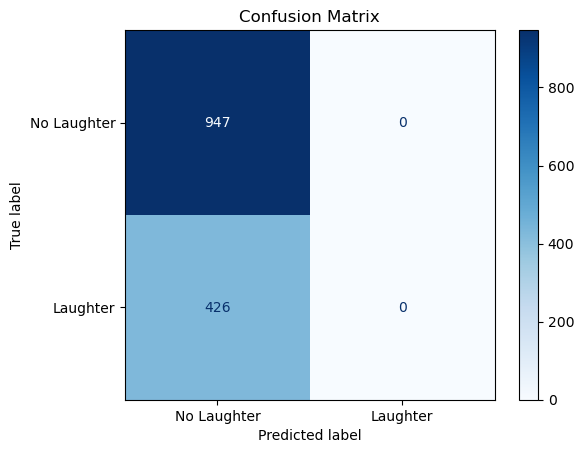

In [45]:
# Evaluate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

-- still the model is not performing better. Will use transformer now

## Building y with transcripts

In [34]:
import os
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def parse_vtt(file_path, audio_file_name):
    """
    Parse a .vtt subtitle file to extract time ranges and laughter indicators.
    
    Args:
        file_path (str): Path to the .vtt file.
        audio_file_name (str): Name of the associated audio file.
        
    Returns:
        pd.DataFrame: DataFrame with columns - 'audio_file_name', 'start_time', 'end_time', 'laughter_indicator'.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    time_pattern = re.compile(r"(\d{2}:\d{2}:\d{2}\.\d{3}) --> (\d{2}:\d{2}:\d{2}\.\d{3})")
    laughter_pattern = re.compile(r"(\[|\(|\{}).*(laugh|cheer|applause|giggle).*?(\]|\)|\})", re.IGNORECASE)
    
    data = []
    
    for i in range(len(lines)):
        match = time_pattern.match(lines[i])
        if match:
            start_time = match.group(1)
            end_time = match.group(2)
            
            text = ""
            j = i + 1
            while j < len(lines) and not lines[j].strip().startswith("NOTE") and "-->" not in lines[j]:
                text += lines[j].strip() + " "
                j += 1
            
            laughter_indicator = 1 if laughter_pattern.search(text) else 0
            
            data.append({
                "audio_file_name": audio_file_name,
                "start_time": start_time,
                "end_time": end_time,
                "laughter_indicator": laughter_indicator
            })
    
    df = pd.DataFrame(data)
    return df

def convert_to_datetime(df):
    """
    Convert start and end times to datetime objects and calculate chunk lengths.
    
    Args:
        df (pd.DataFrame): DataFrame with start and end times.
    
    Returns:
        pd.DataFrame: Updated DataFrame with chunk lengths in seconds.
    """
    df["start_time"] = pd.to_datetime(df["start_time"], format="%H:%M:%S.%f")
    df["end_time"] = pd.to_datetime(df["end_time"], format="%H:%M:%S.%f")
    df["chunk_length"] = (df["end_time"] - df["start_time"]).dt.total_seconds()
    return df


def analyze_laughter_distribution(df):
    """
    Plot laughter distribution over time.
    """
    df["time_since_start"] = (df["start_time"] - df["start_time"].iloc[0]).dt.total_seconds()

    plt.figure(figsize=(10, 6))
    plt.scatter(df["time_since_start"], df["laughter_indicator"], color='red', alpha=0.6, label="Laughter")
    plt.xlabel("Time Since Start (seconds)")
    plt.ylabel("Laughter Indicator")
    plt.title("Laughter Distribution Over Time")
    plt.legend()
    plt.grid()
    plt.show()

def process_all_vtt(folder_path):
    """
    Process all .vtt files in a folder and combine data into a single DataFrame.
    
    Args:
        folder_path (str): Path to the folder containing .vtt files.
    
    Returns:
        pd.DataFrame: Combined DataFrame for all files.
    """
    all_data = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".vtt"):
            file_path = os.path.join(folder_path, file_name)
            audio_file_name = os.path.splitext(file_name)[0] + ".mp3"  # Assuming audio files are named similarly
            df = parse_vtt(file_path, audio_file_name)
            all_data.append(df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Example Usage
folder_path = "kedar_subtitles"
combined_df = process_all_vtt(folder_path)

# Convert times and calculate chunk lengths
combined_df = convert_to_datetime(combined_df)


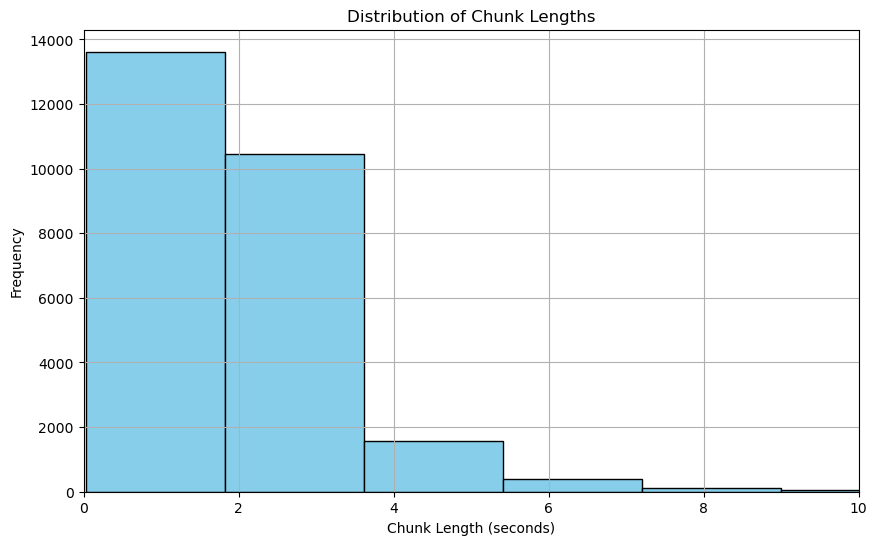

In [26]:

def analyze_chunk_lengths(df):
    """
    Analyze and plot the distribution of chunk lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df["chunk_length"], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Chunk Length (seconds)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Chunk Lengths")
    plt.xlim((0,10))
    plt.grid()
    plt.show()
    
# Analyze chunk lengths
analyze_chunk_lengths(combined_df)


In [36]:
combined_df.head()

,audio_file_name,start_time,end_time,laughter_indicator,chunk_length
0,Are All Dentists Con Artists？ - Joe List - I H...,1900-01-01 00:00:00.734,1900-01-01 00:00:02.002,0,1.268
1,Are All Dentists Con Artists？ - Joe List - I H...,1900-01-01 00:00:02.002,1900-01-01 00:00:03.236,0,1.234
2,Are All Dentists Con Artists？ - Joe List - I H...,1900-01-01 00:00:03.236,1900-01-01 00:00:04.104,0,0.868
3,Are All Dentists Con Artists？ - Joe List - I H...,1900-01-01 00:00:04.104,1900-01-01 00:00:05.638,0,1.534
4,Are All Dentists Con Artists？ - Joe List - I H...,1900-01-01 00:00:05.638,1900-01-01 00:00:07.307,0,1.669


In [38]:
combined_df.to_csv('combined_df.csv')

## Simpler models

In [37]:
target = pd.read_csv('processed_targets_output.csv')
target.head()

,audio_file_name,interval_start,interval_end,target,next_target
0,15 Minutes of Katt Williams.mp3,0,10,0,0
1,15 Minutes of Katt Williams.mp3,10,20,0,0
2,15 Minutes of Katt Williams.mp3,20,30,0,0
3,15 Minutes of Katt Williams.mp3,30,40,0,0
4,15 Minutes of Katt Williams.mp3,40,50,0,0


In [39]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
import tqdm

# Initialize an empty list to store the data
data = []

# Function to compute running mean
def running_mean(values, window_size):
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().values

# Function to compute amplitude-based features
def amplitude_features(y, sr, start_idx, end_idx, running_avg_amp, threshold=0.01, min_silence_duration=0.3):
    """
    Extract amplitude-based features from the audio signal.

    Args:
        y (numpy.ndarray): The audio signal.
        sr (int): Sampling rate of the audio.
        start_idx (int): Start index of the current window.
        end_idx (int): End index of the current window.
        running_avg_amp (float): Running average amplitude over a larger window.
        threshold (float): Amplitude threshold to detect pauses.
        min_silence_duration (float): Minimum duration (in seconds) for a pause to be considered.

    Returns:
        dict: Dictionary of amplitude-based features.
    """
    current_window = y[start_idx:end_idx]
    
    # Compute basic amplitude metrics
    avg_amp = np.mean(np.abs(current_window))
    peak_amp = np.max(np.abs(current_window))
    dynamic_range = peak_amp - np.min(np.abs(current_window))
    peak_to_avg_ratio = peak_amp / avg_amp if avg_amp != 0 else 0
    avg_to_dev_ratio = avg_amp / running_avg_amp if running_avg_amp != 0 else 0

    # Compute zero-crossing rate
    zero_crossings = np.sum(np.abs(np.diff(np.sign(current_window)))) / 2
    zero_crossing_rate = zero_crossings / len(current_window)

    # Compute skewness of amplitude distribution
    amplitude_skewness = skew(np.abs(current_window))

    # Detect pauses
    silence_indices = np.where(np.abs(current_window) < threshold)[0]
    total_pause_duration = 0

    if len(silence_indices) > 0:
        pause_start = silence_indices[0]
        for i in range(1, len(silence_indices)):
            if silence_indices[i] != silence_indices[i - 1] + 1:
                pause_end = silence_indices[i - 1]
                pause_duration = (pause_end - pause_start) / sr
                if pause_duration >= min_silence_duration:
                    total_pause_duration += pause_duration
                pause_start = silence_indices[i]
        # Handle the last segment
        pause_end = silence_indices[-1]
        pause_duration = (pause_end - pause_start) / sr
        if pause_duration >= min_silence_duration:
            total_pause_duration += pause_duration

    return {
        "peak_to_avg_ratio": peak_to_avg_ratio,
        "avg_to_dev_ratio": avg_to_dev_ratio,
        "dynamic_range": dynamic_range,
        "zero_crossing_rate": zero_crossing_rate,
        "amplitude_skewness": amplitude_skewness,
        "total_pause_duration": total_pause_duration,  # Total duration of pauses in seconds
    }
# Function to compute energy-based features
def energy_features(y, sr, start_idx, end_idx, running_avg_energy):
    current_window = y[start_idx:end_idx]
    energy = np.sum(current_window ** 2)
    energy_ratio = energy / running_avg_energy if running_avg_energy != 0 else 0
    energy_decay = np.sum(current_window[:len(current_window)//2] ** 2) - np.sum(current_window[len(current_window)//2:] ** 2)
    return {
        "energy_ratio": energy_ratio,
        "energy_decay": energy_decay,
    }

# Function to compute frequency-based features
def frequency_features(y, sr, start_idx, end_idx):
    current_window = y[start_idx:end_idx]
    spectral_centroid = librosa.feature.spectral_centroid(y=current_window, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=current_window, sr=sr)[0]
    pitches, magnitudes = librosa.piptrack(y=current_window, sr=sr)
    pitch_variation = np.std(pitches[pitches > 0])
    return {
        "spectral_bandwidth": np.mean(spectral_bandwidth),
        "pitch_variation": pitch_variation,
    }

# Function to compute statistical features
def statistical_features(y, sr, start_idx, end_idx):
    current_window = y[start_idx:end_idx]
    std_amp = np.std(np.abs(current_window))
    energy = current_window ** 2
    kurt_energy = kurtosis(energy)
    #autocorr_amp = np.correlate(current_window, current_window, mode="full")[len(current_window) // 2]
    return {
        "std_amp": std_amp,
        "kurt_energy": kurt_energy
        #"autocorr_amp": autocorr_amp,
    }

# Function to compute temporal features
def temporal_features(energy_seq, freq_seq):
    if len(energy_seq) < 2 or len(freq_seq) < 2:
        return {
            "rate_of_change_energy": 0,
            "rate_of_change_frequency": 0,
            "temporal_entropy": 0,
        }
    rate_of_change_energy = np.diff(energy_seq).mean()
    rate_of_change_frequency = np.diff(freq_seq).mean()
    temporal_entropy = -np.sum(energy_seq * np.log2(energy_seq + 1e-10)) / len(energy_seq)
    return {
        "rate_of_change_energy": rate_of_change_energy,
        "rate_of_change_frequency": rate_of_change_frequency,
        "temporal_entropy": temporal_entropy,
    }


In [43]:
from tqdm import tqdm
import os
import librosa

data = []  # Store extracted features
audio_folder = "audio_files_22_nov"

target_df = target


# Outer loop for audio files with tqdm progress bar
for file_name in tqdm(os.listdir(audio_folder), desc="Processing audio files"):
    if file_name.endswith(".mp3"):
        file_path = os.path.join(audio_folder, file_name)
        audio_file_name = file_name
        y, sr = librosa.load(file_path, sr=16000, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)
        num_intervals = int(duration // 10)

        # Compute running mean amplitude and energy
        running_avg_amp = running_mean(np.abs(y), sr * 60)
        running_avg_energy = running_mean(y ** 2, sr * 60)

        # Inner loop for intervals with tqdm progress bar
        #for i in tqdm(range(num_intervals), desc="Processing intervals"):
        for i in range(num_intervals):
            start_idx = i * sr * 10
            end_idx = (i + 1) * sr * 10

            # Compute features
            amp_features = amplitude_features(y, sr, start_idx, end_idx, running_avg_amp[start_idx])
            energy_features_dict = energy_features(y, sr, start_idx, end_idx, running_avg_energy[start_idx])
            #freq_features = frequency_features(y, sr, start_idx, end_idx)
            stat_features = statistical_features(y, sr, start_idx, end_idx)
            #temp_features = temporal_features(running_avg_energy[start_idx:end_idx], running_avg_amp[start_idx:end_idx])

            # Combine features
            features = {**amp_features, **energy_features_dict, **stat_features}
            features["audio_file_name"] = audio_file_name
            features["start_time"] = i * 10
            features["end_time"] = (i + 1) * 10

            # Fetch the corresponding target value
            try:
                features["next_target"] = target_df.loc[
                    (target_df["audio_file_name"] == audio_file_name) &
                    (target_df["interval_start"] == i * 10), "next_target"
                ].values[0]
            except IndexError:
                features["next_target"] = None  # Handle missing targets gracefully

            data.append(features)

# Convert collected data into a DataFrame
features_df = pd.DataFrame(data)

Processing audio files: 100%|███████████████████| 57/57 [02:17<00:00,  2.42s/it]


In [44]:
features_df.to_csv('amplitude_based_features_df_27_Nov.csv')

In [1]:
import pandas as pd
#features_df2 = pd.read_csv('amplitude_based_features_df_27_Nov.csv')

In [11]:
features_df = features_df2.drop(['Unnamed: 0'],axis=1)

In [13]:
features_df.head()

,peak_to_avg_ratio,avg_to_dev_ratio,dynamic_range,zero_crossing_rate,amplitude_skewness,total_pause_duration,energy_ratio,energy_decay,std_amp,kurt_energy,audio_file_name,start_time,end_time,next_target
0,33.515247,0.000000,0.610390,0.142572,4.375349,1.554312,0.000000,80.945390,0.030013,843.963751,When You’re the Only Black Friend in the Group...,0,10,0
1,24.269381,1.018756,0.450289,0.150169,3.802149,2.409000,188253.853478,-34.098335,0.033255,141.902241,When You’re the Only Black Friend in the Group...,10,20,0
2,14.876110,2.280967,0.623786,0.164794,2.539163,0.670312,618718.576997,-359.943100,0.058555,63.653296,When You’re the Only Black Friend in the Group...,20,30,0
3,24.821348,1.092758,0.711528,0.154275,4.003118,1.256875,224427.614512,521.896900,0.053458,166.726048,When You’re the Only Black Friend in the Group...,30,40,0
4,36.243160,0.740800,0.720652,0.129975,4.767340,0.448062,83933.570113,109.409450,0.033455,678.251292,When You’re the Only Black Friend in the Group...,40,50,1


In [35]:

features_df.groupby(pd.qcut(features_df['total_pause_duration'], q = 10, duplicates = 'drop')).agg({'next_target':['sum','count']})/features_df.shape[0]

next_target          
                             sum     count
total_pause_duration                      
(-0.001, 0.367]         0.237249  0.699942
(0.367, 0.734]          0.029146  0.099971
(0.734, 1.398]          0.025794  0.099971
(1.398, 10.0]           0.018362  0.100117

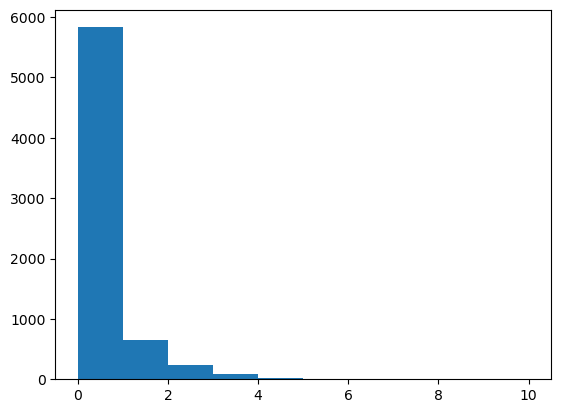

In [39]:
import matplotlib.pyplot as plt
plt.hist(features_df['total_pause_duration'])
plt.show()

In [27]:
pd.qcut(features_df['total_pause_duration'], q = 10, duplicates = 'drop')

0         (1.398, 10.0]
1         (1.398, 10.0]
2        (0.367, 0.734]
3        (0.734, 1.398]
4        (0.367, 0.734]
             ...       
6857     (0.734, 1.398]
6858    (-0.001, 0.367]
6859     (0.734, 1.398]
6860    (-0.001, 0.367]
6861     (0.734, 1.398]
Name: total_pause_duration, Length: 6862, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 0.367] < (0.367, 0.734] < (0.734, 1.398] < (1.398, 10.0]]

In [41]:
features_df.columns

Index(['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
       'audio_file_name', 'start_time', 'end_time', 'next_target'],
      dtype='object')

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset (replace 'your_dataframe.csv' with your actual file)
df = features_df


# Split based on audio files
audio_files = df["audio_file_name"].unique()
train_files, test_files = train_test_split(audio_files, test_size=0.2, random_state=42)

# Assign rows to train and test sets
train_df = df[df["audio_file_name"].isin(train_files)]
test_df = df[df["audio_file_name"].isin(test_files)]

# Prepare features (X) and target (y)
X_train = train_df[['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
        'start_time', 'end_time']]
y_train = train_df['next_target']

X_test = test_df[['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
        'start_time', 'end_time']]
y_test = test_df['next_target']



# Standardize the features (important for some models, e.g., Random Forest)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define hyperparameters for Decision Tree and Random Forest
dt_params = {
    'max_depth': [5, 10, 15, None]
}

rf_params = {
    'n_estimators': [50, 100, 200, 500]
}

# Initialize models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# GridSearchCV for Decision Tree
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Best Decision Tree Model
best_dt = dt_grid.best_estimator_
print("Best parameters for Decision Tree:", dt_grid.best_params_)

# GridSearchCV for Random Forest
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best Random Forest Model
best_rf = rf_grid.best_estimator_
print("Best parameters for Random Forest:", rf_grid.best_params_)


# Evaluate both models on the test set
for model, name in zip([best_dt, best_rf], ["Decision Tree", "Random Forest"]):
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Decision Tree: {'max_depth': 5}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Random Forest: {'n_estimators': 100}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       871
           1       0.47      0.20      0.28       444

    accuracy                           0.65      1315
   macro avg       0.58      0.54      0.53      1315
weighted avg       0.61      0.65      0.61      1315

Confusion Matrix:
[[769 102]
 [354  90]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       871
           1       0.47      0.21      0.29       444

    accuracy                           0.65      1315
   macro avg       0.58      0.55      0.53      1315
weighted avg       0.61      0.65      0.61      1315



In [44]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Set up the parameter grid for 5-fold cross-validation
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [50, 100, 200],
    "subsample": [0.8, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Print classification report
print("Boosting Tree Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Boosting Tree Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       871
           1       0.00      0.00      0.00       444

    accuracy                           0.66      1315
   macro avg       0.33      0.50      0.40      1315
weighted avg       0.44      0.66      0.53      1315



/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision

In [45]:
1 - y_test.sum()/y_test.shape[0]

0.6623574144486692

Decision Tree AUC: 0.6243
Random Forest AUC: 0.5901
XG Boost AUC: 0.6264


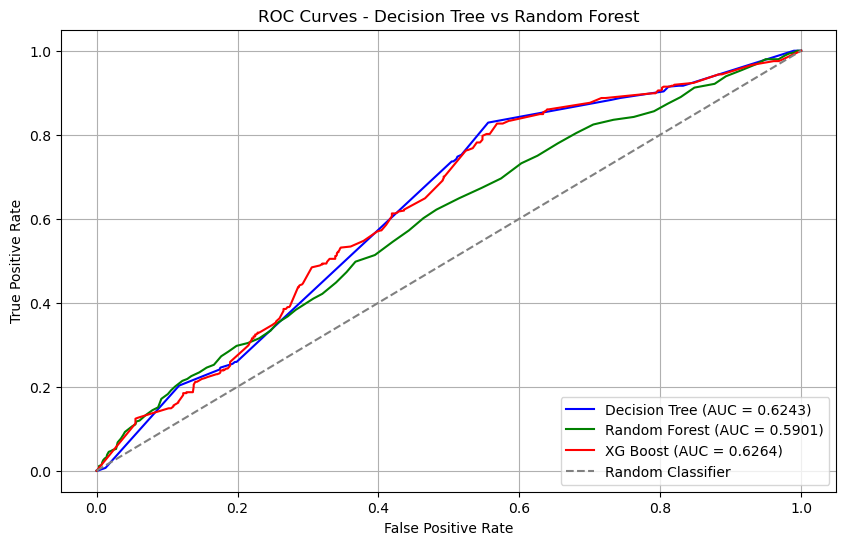

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(10, 6))

# Evaluate AUC for both models and plot on the same figure
for model, name, color in zip([best_dt, best_rf,best_model], ["Decision Tree", "Random Forest","XG Boost"], ["blue", "green","red"]):
    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} AUC: {auc:.4f}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", color=color)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

# Customize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Decision Tree vs Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()



## Feature Importance

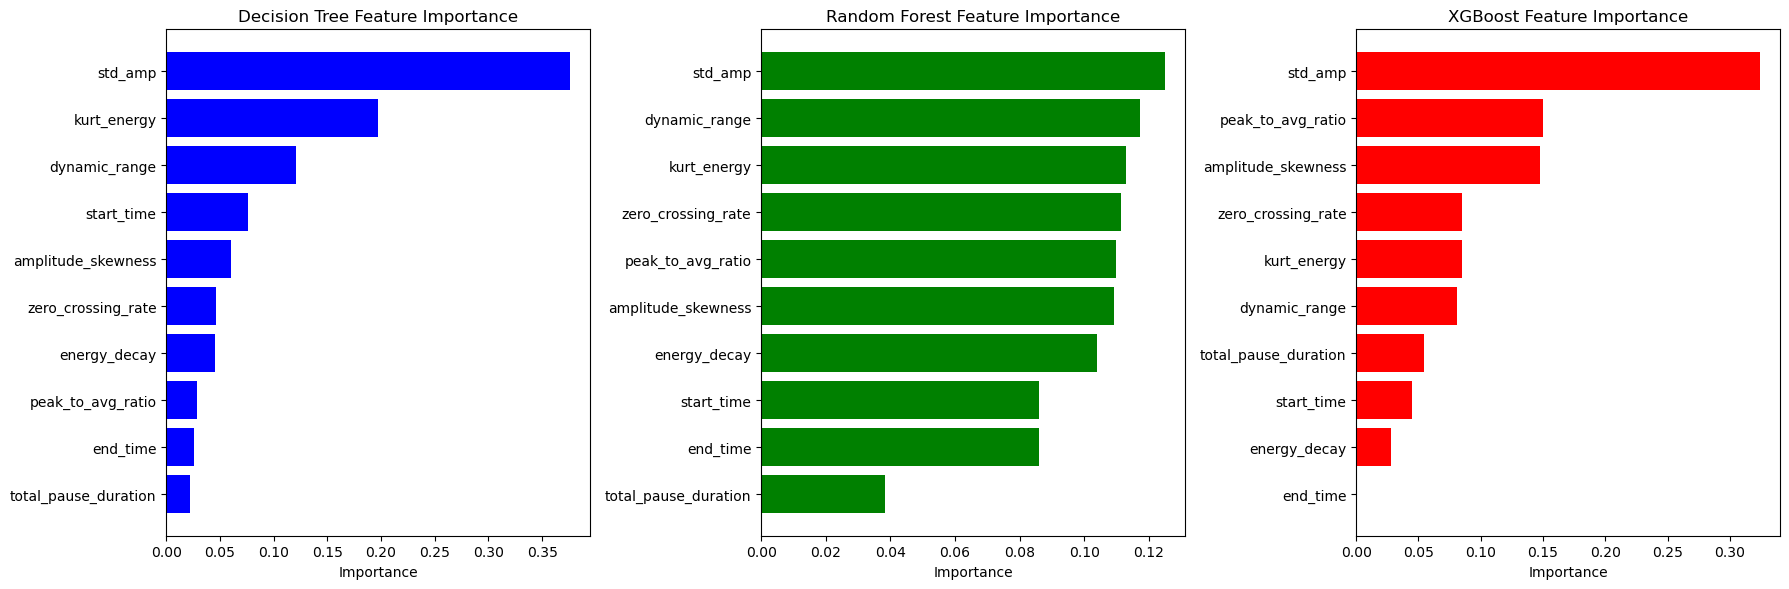

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot feature importance for Decision Tree, Random Forest, and XGBoost
def plot_feature_importances(models, model_names, feature_names, top_n=10):
    plt.figure(figsize=(18, 6))
    
    for i, (model, name, color) in enumerate(zip(models, model_names, ["blue", "green", "red"])):
        if hasattr(model, "feature_importances_"):  # Check if model has feature_importances_
            importances = model.feature_importances_
            sorted_idx = np.argsort(importances)[-top_n:]  # Get top_n feature indices
            sorted_features = feature_names[sorted_idx]
            sorted_importances = importances[sorted_idx]
            
            plt.subplot(1, 3, i + 1)
            plt.barh(sorted_features, sorted_importances, color=color)
            plt.xlabel("Importance")
            plt.title(f"{name} Feature Importance")
            plt.tight_layout()
    
    plt.show()

# Assuming X_train is a DataFrame
X_train = train_df[['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
        'start_time', 'end_time']]


feature_names = X_train.columns

# Call the function with best_dt, best_rf, and best_model
plot_feature_importances(
    models=[best_dt, best_rf, best_model],
    model_names=["Decision Tree", "Random Forest", "XGBoost"],
    feature_names=feature_names
)

In [67]:
from sklearn.tree import export_graphviz
from graphviz import Source

# Export the decision tree to DOT format
dot_data = export_graphviz(
    best_dt,  # The trained decision tree model
    out_file=None,  # Output file (None means return as a string)
    feature_names=X_train.columns,  # Feature names
    class_names=['No Laughter', 'Laughter'],  # Class names
    filled=True,  # Fill nodes with colors
    rounded=True,  # Use rounded corners for nodes
    special_characters=True  # Allow special characters like '<' and '>'
)

# Use Graphviz to render the DOT data
graph = Source(dot_data)

# Save and display the graph
graph.render("decision_tree_visualization", format="png", cleanup=True)  # Save as PNG
graph.view()  # Display the decision tree

'decision_tree_visualization.pdf'

### Learning Curve

Processing sample size: 2
Processing sample size: 4
Processing sample size: 6
Processing sample size: 8
Processing sample size: 10
Processing sample size: 12
Processing sample size: 14
Processing sample size: 16
Processing sample size: 18
Processing sample size: 20
Processing sample size: 22
Processing sample size: 24
Processing sample size: 26
Processing sample size: 28
Processing sample size: 30
Processing sample size: 32
Processing sample size: 34
Processing sample size: 36
Processing sample size: 38
Processing sample size: 40
Processing sample size: 42
Processing sample size: 44
Processing sample size: 46
Processing sample size: 48
Processing sample size: 50
Processing sample size: 52
Processing sample size: 54


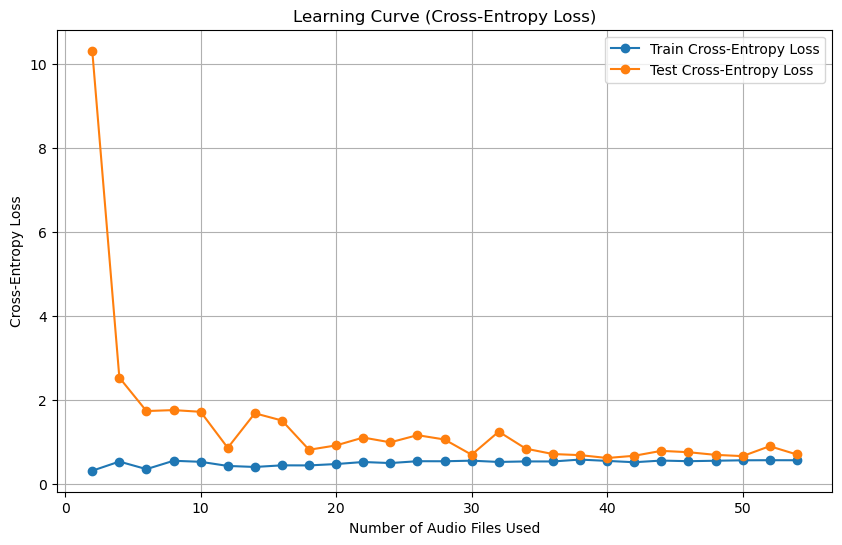

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import log_loss

# Initialize lists for storing train and test errors
train_errors = []
test_errors = []

# Sample sizes to evaluate
sample_sizes = list(range(2, 56, 2))

# Function to filter data by audio files
def get_data_for_audio_files(df, audio_files):
    filtered_df = df[df['audio_file_name'].isin(audio_files)]
    X = filtered_df[['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
        'start_time', 'end_time']]
    y = filtered_df['next_target']
    
    return X, y

# Loop through each sample size
for sample_size in sample_sizes:
    print(f"Processing sample size: {sample_size}")

    # Randomly sample audio file names
    sampled_audio_files = random.sample(features_df['audio_file_name'].unique().tolist(), sample_size)

    # Prepare data for sampled audio files
    X, y = get_data_for_audio_files(features_df, sampled_audio_files)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    df = features_df

    # Fit the Decision Tree model
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_train, y_train)

     # Compute train and test errors (cross-entropy loss)
    train_proba = model.predict_proba(X_train)
    test_proba = model.predict_proba(X_test)

    train_error = log_loss(y_train, train_proba)
    test_error = log_loss(y_test, test_proba)

    train_errors.append(train_error)
    test_errors.append(test_error)


# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, label="Train Cross-Entropy Loss", marker="o")
plt.plot(sample_sizes, test_errors, label="Test Cross-Entropy Loss", marker="o")
plt.xlabel("Number of Audio Files Used")
plt.ylabel("Cross-Entropy Loss")
plt.title("Learning Curve (Cross-Entropy Loss)")
plt.legend()
plt.grid()
plt.show()

### Adding lookback features

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = features_df

# Define the look-back window size
lookback = 5

# Initialize a list to store processed data
processed_data = []

# Group by audio file to process each file independently
for audio_file, group in df.groupby("audio_file_name"):
    group = group.sort_values("start_time").reset_index(drop=True)

    # Skip files with insufficient windows
    if len(group) <= lookback:
        continue

    # Create look-back features
    for i in range(lookback, len(group)):
        row = group.iloc[i].copy()

        # Append look-back features
        for j in range(1, lookback + 1):
            lookback_row = group.iloc[i - j]
            for col in ['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
           'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
           'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
            'start_time', 'end_time']:
                row[f"{col}_t-{j}"] = lookback_row[col]

        processed_data.append(row)

# Combine processed data into a new DataFrame
processed_df = pd.DataFrame(processed_data)

# Split based on audio files
audio_files = processed_df["audio_file_name"].unique()
train_files, test_files = train_test_split(audio_files, test_size=0.2, random_state=42)

# Assign rows to train and test sets
train_df = processed_df[processed_df["audio_file_name"].isin(train_files)]
test_df = processed_df[processed_df["audio_file_name"].isin(test_files)]

# Prepare features (X) and target (y)
X_train = train_df.drop(columns=['audio_file_name', 'start_time', 'end_time', 'next_target'])
y_train = train_df['next_target']
X_test = test_df.drop(columns=['audio_file_name', 'start_time', 'end_time', 'next_target'])
y_test = test_df['next_target']

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display processed shapes
print(f"Processed DataFrame shape: {processed_df.shape}")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Processed DataFrame shape: (6577, 74)
X_train shape: (4791, 70), X_test shape: (1786, 70)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:14:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


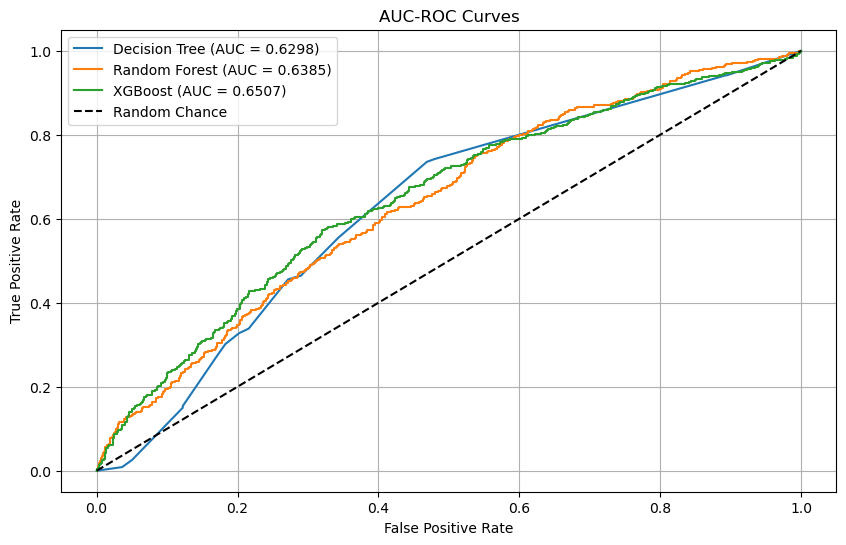

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False)
}

# Fit models and compute AUC-ROC
auc_scores = {}
roc_curves = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores[name] = auc_score
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_curves[name] = (fpr, tpr)

# Plot AUC-ROC curves
plt.figure(figsize=(10, 6))

for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_scores[name]:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves")
plt.legend()
plt.grid()
plt.show()

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define parameter grids for each model
param_grids = {
    "Decision Tree": {
        "max_depth": [3, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 1000]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
}

# Perform grid search for each model
best_models = {}
for name, model in models.items():
    print(f"Performing GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], scoring="roc_auc", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Performing GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 3}
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'n_estimators': 200}
Performing GridSearchCV for XGBoost...


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:15:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


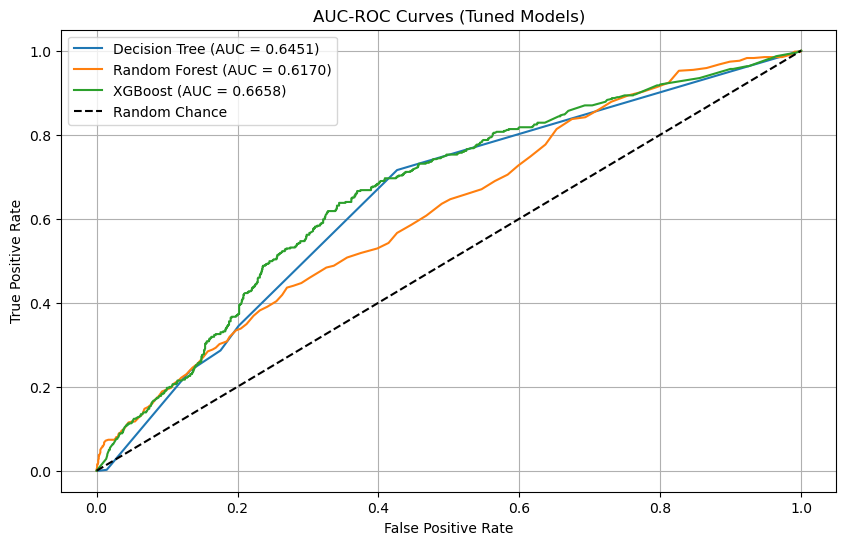

In [72]:

# Evaluate the models on the test set
auc_scores = {}
roc_curves = {}

for name, model in best_models.items():
    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores[name] = auc_score
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_curves[name] = (fpr, tpr)

# Plot AUC-ROC curves
plt.figure(figsize=(10, 6))

for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_scores[name]:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves (Tuned Models)")
plt.legend()
plt.grid()
plt.show()

In [117]:
import joblib
import os

# Directory to save models
export_dir = "feature_engg_vars"
os.makedirs(export_dir, exist_ok=True)

# Export each model
for name, model in best_models.items():
    file_path = os.path.join(export_dir, f"{name.replace(' ', '_')}_model.pkl")
    joblib.dump(model, file_path)
    print(f"{name} model exported to {file_path}")

Decision Tree model exported to feature_engg_vars/Decision_Tree_model.pkl
Random Forest model exported to feature_engg_vars/Random_Forest_model.pkl
XGBoost model exported to feature_engg_vars/XGBoost_model.pkl


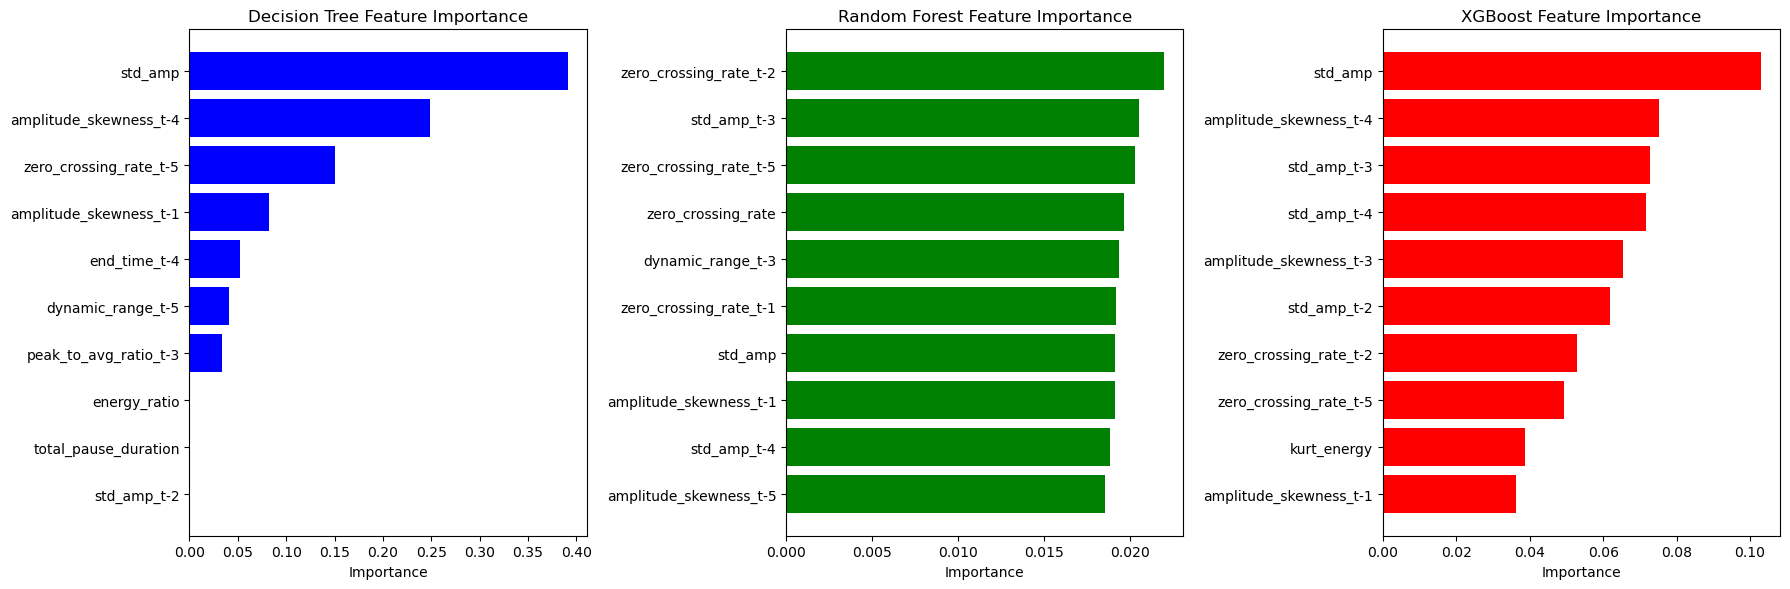

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot feature importance for Decision Tree, Random Forest, and XGBoost
def plot_feature_importances(models, model_names, feature_names, top_n=10):
    plt.figure(figsize=(18, 6))
    
    for i, (model, name, color) in enumerate(zip(models, model_names, ["blue", "green", "red"])):
        if hasattr(model, "feature_importances_"):  # Check if model has feature_importances_
            importances = model.feature_importances_
            sorted_idx = np.argsort(importances)[-top_n:]  # Get top_n feature indices
            sorted_features = feature_names[sorted_idx]
            sorted_importances = importances[sorted_idx]
            
            plt.subplot(1, 3, i + 1)
            plt.barh(sorted_features, sorted_importances, color=color)
            plt.xlabel("Importance")
            plt.title(f"{name} Feature Importance")
            plt.tight_layout()
    
    plt.show()

# Assuming X_train is a DataFrame
X_train = train_df.drop(columns=['audio_file_name', 'start_time', 'end_time', 'next_target'])


feature_names = X_train.columns

models = []
names = []

for name, model in best_models.items():
    models.append(model)
    names.append(name)

# Call the function with best_dt, best_rf, and best_model
plot_feature_importances(
    models,
    names,
    feature_names=feature_names
)